In [20]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from sklearn.linear_model import LogisticRegression
from transformers import pipeline
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from wordcloud import WordCloud

In [14]:
# Make dataframe local variable
data = pd.read_csv("/Users/scottpetersen/Desktop/ECON1680/ECON1680-Project-2-Scott-Petersen/Data/Twitter Jan Mar 2.csv", encoding='latin1')

# Verify that the data is available
print(data.head(5))

                        date                   id  \
0  2023-03-29 22:58:21+00:00  1641213230730051584   
1  2023-03-29 22:58:18+00:00  1641213218520481805   
2  2023-03-29 22:57:53+00:00  1641213115684536323   
3  2023-03-29 22:57:52+00:00  1641213110915571715   
4  2023-03-29 22:57:26+00:00  1641213003260633088   

                                             content        username  \
0  Free AI marketing and automation tools, strate...  RealProfitPros   
1      @MecoleHardman4 Chat GPT says itâs 15. ð    AmyLouWho321   
2  https://t.co/FjJSprt0te - Chat with any PDF!\n...      yjleon1976   
3  AI muses: "In the court of life, we must all f...  ChatGPT_Thinks   
4  Most people haven't heard of Chat GPT yet.\nFi...   nikocosmonaut   

   like_count  retweet_count  
0         0.0            0.0  
1         0.0            0.0  
2         0.0            0.0  
3         0.0            0.0  
4         0.0            0.0  


In [4]:
# Check missing values in the 'content' column
missing_content = data[data['content'].isnull()]

# Drop rows with missing content
data.dropna(subset=['content'], inplace=True)

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

In [7]:
# Create a new truncated subset of data
data_subset = data.head(5000).copy()

In [9]:
# Code to instantiate the ENTIRE dataset as a local variable

# Instantiate an empty list to store tweet
cleantweet=[]

# For each row in df, iterate
for i in range(len(data)):

    # Current tweet becomes original tweet at i
    tweet=data['content'][i] 
    tweet=tweet.replace('\r',' ') #Replace all different characters with spaces (as with all below)
    tweet=tweet.replace('\n',' ') #Replace newline chars
    tweet=tweet.replace('. ',' ') #replace periods
    tweet=tweet.replace(', ',' ') #replace commas
    tokens = tweet.split(' ') #Turn tweets into a list of tokens
    tweet_hashtags=[] #Create a hashtag list
    tweet_token=[] #Create a list for each tweet's tokens
    for t in tokens: #Loop through tokens
        if "https:" not in t: #Only add tokens that don't include https:
            tweet_token.append(t) #Add non https:
    cleantweet.append(" ".join(tweet_token).lower()) #Add tokens to the cleaned tweet list
data['clean tweet']= cleantweet #Add to df_tweet in clean tweet row

#### Below Takes a few min to run. 5-10
similar_level=85 #Sets baseline similarity lvl
duplicate_index = [] #Initializes list for tweet pairs

for original in range(len(data)-1): #Loops through most of df_tweet
    print((original / len(data) * 100), '%' ) #Prints progress
    for compared in range(original+1, len(data)): #Compares each tweet to the other tweets
        if compared not in duplicate_index: #If current tweet not alr in list of indices
            if fuzz.ratio(data['clean tweet'][original], data['clean tweet'][compared]) >= similar_level: #Compares similarity of chosen tweets and others to threshold
                duplicate_index.append(compared) #If similar, add index to duplicate
data.drop(duplicate_index, inplace=True)
data.reset_index(drop=True, inplace=True)

ValueError: Length of values (5000) does not match length of index (500030)

In [9]:
# Code to instantiate the ENTIRE dataset as a local variable

# Instantiate an empty list to store tweet
cleantweet=[]

# For each row in df, iterate
for i in range(len(data_subset)):

    # Current tweet becomes original tweet at i
    tweet=data_subset['content'][i] 
    tweet=tweet.replace('\r',' ') #Replace all different characters with spaces (as with all below)
    tweet=tweet.replace('\n',' ') #Replace newline chars
    tweet=tweet.replace('. ',' ') #replace periods
    tweet=tweet.replace(', ',' ') #replace commas
    tokens = tweet.split(' ') #Turn tweets into a list of tokens
    tweet_hashtags=[] #Create a hashtag list
    tweet_token=[] #Create a list for each tweet's tokens
    for t in tokens: #Loop through tokens
        if "https:" not in t: #Only add tokens that don't include https:
            tweet_token.append(t) #Add non https:
    cleantweet.append(" ".join(tweet_token).lower()) #Add tokens to the cleaned tweet list
data_subset['clean tweet']= cleantweet #Add to df_tweet in clean tweet row

#### Below Takes a few min to run. 5-10
similar_level=85 #Sets baseline similarity lvl
duplicate_index = [] #Initializes list for tweet pairs

for original in range(len(data_subset)-1): #Loops through most of df_tweet
    print((original / len(data_subset) * 100), '%' ) #Prints progress
    for compared in range(original+1, len(data_subset)): #Compares each tweet to the other tweets
        if compared not in duplicate_index: #If current tweet not alr in list of indices
            if fuzz.ratio(data_subset['clean tweet'][original], data_subset['clean tweet'][compared]) >= similar_level: #Compares similarity of chosen tweets and others to threshold
                duplicate_index.append(compared) #If similar, add index to duplicate
data_subset.drop(duplicate_index, inplace=True)
data_subset.reset_index(drop=True, inplace=True)

0.0 %
0.02 %
0.04 %
0.06 %
0.08 %
0.1 %
0.12 %
0.13999999999999999 %
0.16 %
0.18 %
0.2 %
0.22 %
0.24 %
0.26 %
0.27999999999999997 %
0.3 %
0.32 %
0.33999999999999997 %
0.36 %
0.38 %
0.4 %
0.42 %
0.44 %
0.45999999999999996 %
0.48 %
0.5 %
0.52 %
0.54 %
0.5599999999999999 %
0.58 %
0.6 %
0.62 %
0.64 %
0.66 %
0.6799999999999999 %
0.7000000000000001 %
0.72 %
0.74 %
0.76 %
0.7799999999999999 %
0.8 %
0.8200000000000001 %
0.84 %
0.86 %
0.88 %
0.8999999999999999 %
0.9199999999999999 %
0.9400000000000001 %
0.96 %
0.98 %
1.0 %
1.02 %
1.04 %
1.06 %
1.08 %
1.0999999999999999 %
1.1199999999999999 %
1.1400000000000001 %
1.16 %
1.18 %
1.2 %
1.22 %
1.24 %
1.26 %
1.28 %
1.3 %
1.32 %
1.34 %
1.3599999999999999 %
1.38 %
1.4000000000000001 %
1.4200000000000002 %
1.44 %
1.46 %
1.48 %
1.5 %
1.52 %
1.54 %
1.5599999999999998 %
1.58 %
1.6 %
1.6199999999999999 %
1.6400000000000001 %
1.66 %
1.68 %
1.7000000000000002 %
1.72 %
1.7399999999999998 %
1.76 %
1.78 %
1.7999999999999998 %
1.82 %
1.8399999999999999 %
1.859999

In [15]:
#Code to clean the data and write it to a new csv file

# Words to clean
words_to_clean = ["chatgpt", "ai", "gpt", "chat", "gpt4", "https", "artificialintelligence"]

# Instantiate an empty list to store cleaned tweets
clean_tweets = []

# Iterate over each tweet in data_subset
for tweet in data_subset['content']:
    # Clean tweet by replacing specified words with spaces
    cleaned_tweet = tweet.lower()
    for word in words_to_clean:
        cleaned_tweet = cleaned_tweet.replace(word, '')
    # Replace special characters with spaces
    cleaned_tweet = cleaned_tweet.replace('\r',' ')
    cleaned_tweet = cleaned_tweet.replace('\n',' ')
    cleaned_tweet = cleaned_tweet.replace('. ',' ')
    cleaned_tweet = cleaned_tweet.replace(', ',' ')
    # Append cleaned tweet to the list
    clean_tweets.append(cleaned_tweet.strip())  # strip removes leading/trailing whitespaces

# Add cleaned tweets to data_subset
data_subset['clean_tweet'] = clean_tweets

# Remove duplicates based on similarity
similar_level = 85  # Sets baseline similarity level
duplicate_index = []  # Initializes list for tweet indices to remove

for original in range(len(data_subset)-1):
    print((original / len(data_subset) * 100), '%')
    for compared in range(original+1, len(data_subset)):
        if compared not in duplicate_index:
            if fuzz.ratio(data_subset['clean_tweet'][original], data_subset['clean_tweet'][compared]) >= similar_level:
                duplicate_index.append(compared)

# Drop duplicate tweets
data_subset.drop(duplicate_index, inplace=True)
data_subset.reset_index(drop=True, inplace=True)

# Write cleaned data to a new CSV file
data_subset.to_csv('data/data_5,000_rows.csv', index=False)

0.0 %
0.02090738030524775 %
0.0418147606104955 %
0.06272214091574327 %
0.083629521220991 %
0.10453690152623876 %
0.12544428183148654 %
0.14635166213673428 %
0.167259042441982 %
0.18816642274722975 %
0.20907380305247752 %
0.2299811833577253 %
0.2508885636629731 %
0.2717959439682208 %
0.29270332427346857 %
0.3136107045787163 %
0.334518084883964 %
0.35542546518921175 %
0.3763328454944595 %
0.3972402257997073 %
0.41814760610495505 %
0.43905498641020285 %
0.4599623667154506 %
0.48086974702069835 %
0.5017771273259461 %
0.5226845076311939 %
0.5435918879364416 %
0.5644992682416894 %
0.5854066485469371 %
0.6063140288521849 %
0.6272214091574326 %
0.6481287894626803 %
0.669036169767928 %
0.6899435500731758 %
0.7108509303784235 %
0.7317583106836713 %
0.752665690988919 %
0.7735730712941669 %
0.7944804515994146 %
0.8153878319046624 %
0.8362952122099101 %
0.857202592515158 %
0.8781099728204057 %
0.8990173531256535 %
0.9199247334309012 %
0.940832113736149 %
0.9617394940413967 %
0.9826468743466444 %
1.

In [16]:
# Create a count vectorizer with specified parameters
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english') 

# Transform newly cleaned tweets into a bag-of-words representation
bow_representation = vectorizer.fit_transform(data_subset['clean_tweet'])

# Set hyperparameter for num_topics
num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=1680)
lda_model.fit(bow_representation)


feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])

Topic 1:
['open', 'tech', 'technology', 'ask', 'elonmusk', 'machinelearning', 'read', 'just', 'cybersecurity', 'human']
Topic 2:
['like', 'open', 'use', 'amp', 'just', 'people', 'good', 'jobs', 'google', 'thing']
Topic 3:
['open', 'pause', 'elon', 'musk', 'elonmusk', 'development', 'use', 'letter', 'powerful', 'systems']
Topic 4:
['use', 'open', 'like', 'using', 'bing', 'know', 'microsoft', 'technology', 'new', 'work']
Topic 5:
['make', 'generated', 'art', 'intelligence', 'open', 'prompt', 'create', 'artificial', 'write', 'midjourney']
Topic 6:
['like', 'using', 'just', 'amp', 'midjourney', 'open', 'bitcoin', 'does', 'btc', 'help']
Topic 7:
['open', 'article', 'language', 'amp', 'latest', 'technology', 'new', 'check', 'help', 'humans']
Topic 8:
['bard', 'google', 'like', 'tools', 'look', 'news', 'amp', 'trading', 'stocks', 'options']
Topic 9:
['just', 'open', 'new', 'future', 'like', 'content', 'using', 'video', 'make', 'tools']
Topic 10:
['gt', 'world', 'asked', 'just', 'nft', 'write'

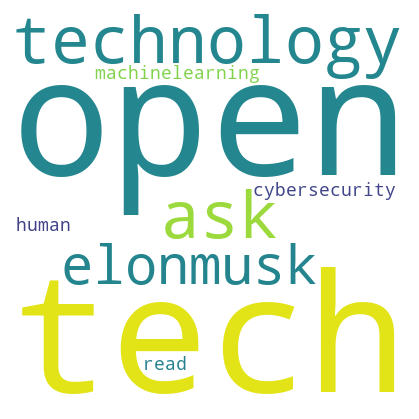

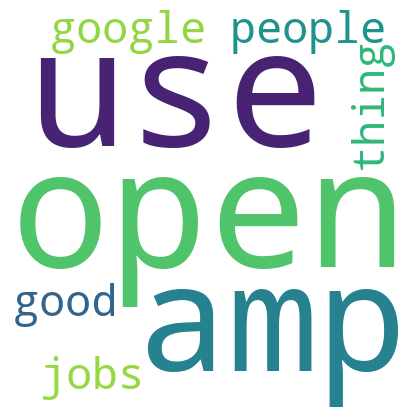

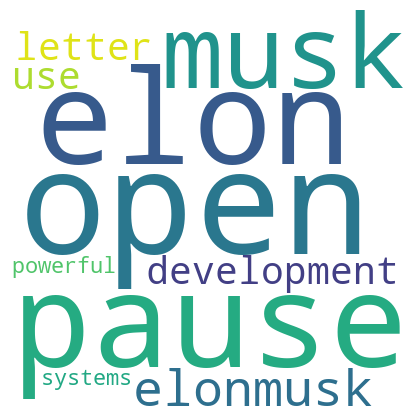

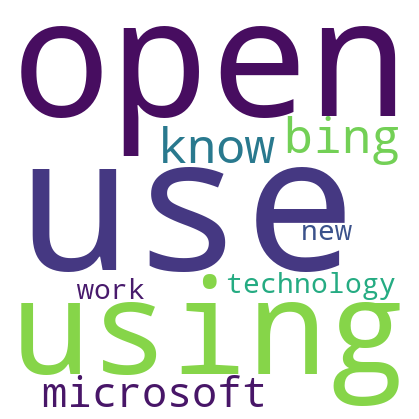

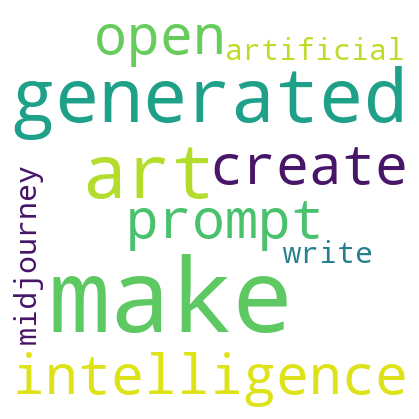

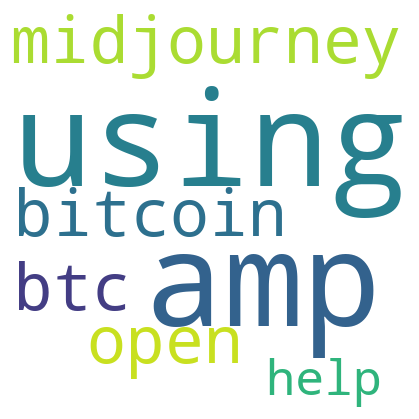

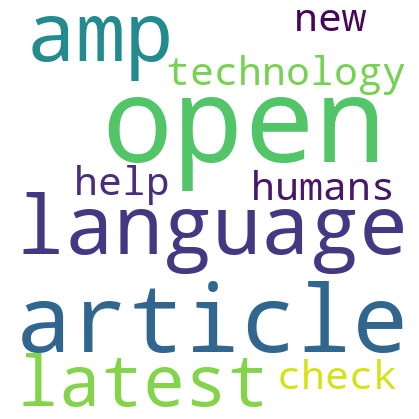

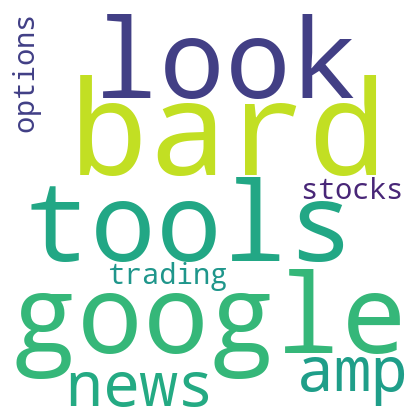

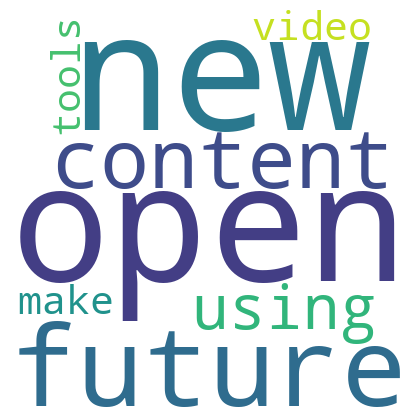

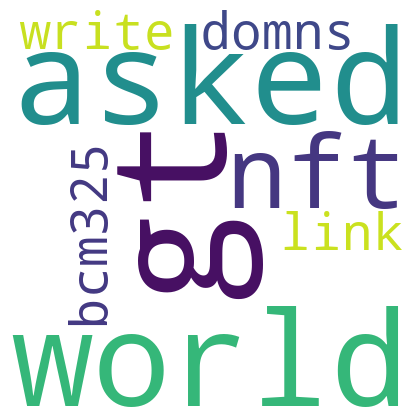

In [24]:
# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    # Get top words for the topic
    top_words_indices = topic.argsort()[:-10 - 1:-1]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_indices]  # Get actual words
    
    # Create word cloud object with smaller dimensions
    wordcloud = WordCloud(width = 400, height = 400,  # Adjust width and height
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 10).generate(' '.join(top_words))
    
    # Plot word cloud
    plt.figure(figsize = (4, 4), facecolor = None)  # Adjust figure size
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    # Save or display the word cloud
    plt.savefig(f"topic_{topic_idx+1}_wordcloud.png")  # Save word cloud as an image
    plt.show()  # Display word cloud

In [19]:
# Calculate average like count and average retweet count for each topic
topic_stats = pd.DataFrame(index=range(num_topics), columns=['Average Like Count', 'Average Retweet Count'])

for topic_idx, topic in enumerate(lda_model.components_):
    # Get indices of tweets belonging to the current topic
    topic_indices = lda_model.transform(bow_representation).argmax(axis=1) == topic_idx
    # Calculate average like count and average retweet count for tweets in this topic
    topic_like_count = data_subset.loc[topic_indices, 'like_count'].mean()
    topic_retweet_count = data_subset.loc[topic_indices, 'retweet_count'].mean()
    # Store the averages in the DataFrame
    topic_stats.loc[topic_idx] = [topic_like_count, topic_retweet_count]

# Sort topics based on average like count
sorted_topics_by_like = topic_stats.sort_values(by='Average Like Count', ascending=False)

# Sort topics based on average retweet count
sorted_topics_by_retweet = topic_stats.sort_values(by='Average Retweet Count', ascending=False)

# Display the sorted topics along with their associated average like count and average retweet count
print("\nTopics re-ranked by Average Like Count:")
for idx, row in sorted_topics_by_like.iterrows():
    print(f"Topic {idx + 1}: Avg Like Count={row['Average Like Count']}, Avg Retweet Count={row['Average Retweet Count']}")

print("\nTopics re-ranked by Average Retweet Count:")
for idx, row in sorted_topics_by_retweet.iterrows():
    print(f"Topic {idx + 1}: Avg Like Count={row['Average Like Count']}, Avg Retweet Count={row['Average Retweet Count']}")



Topics re-ranked by Average Like Count:
Topic 8: Avg Like Count=40.02670623145401, Avg Retweet Count=1.7952522255192878
Topic 5: Avg Like Count=4.023980815347722, Avg Retweet Count=1.1414868105515588
Topic 3: Avg Like Count=3.707158351409978, Avg Retweet Count=0.7852494577006508
Topic 4: Avg Like Count=2.965732087227414, Avg Retweet Count=0.2881619937694704
Topic 7: Avg Like Count=2.9129287598944593, Avg Retweet Count=0.7150395778364116
Topic 6: Avg Like Count=2.9029345372460496, Avg Retweet Count=0.5372460496613995
Topic 9: Avg Like Count=2.669104204753199, Avg Retweet Count=0.489945155393053
Topic 2: Avg Like Count=2.525305410122164, Avg Retweet Count=0.33507853403141363
Topic 10: Avg Like Count=1.9125, Avg Retweet Count=0.2625
Topic 1: Avg Like Count=1.5672413793103448, Avg Retweet Count=0.3741379310344828

Topics re-ranked by Average Retweet Count:
Topic 8: Avg Like Count=40.02670623145401, Avg Retweet Count=1.7952522255192878
Topic 5: Avg Like Count=4.023980815347722, Avg Retweet

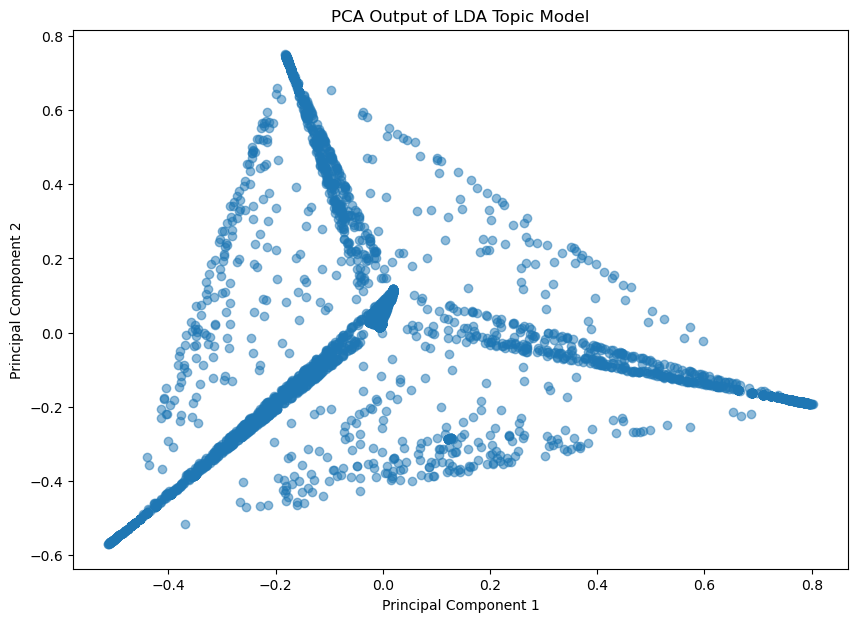

In [13]:
num_components = 2  
pca = PCA(n_components=num_components)

lda_output = lda_model.fit_transform(bow_representation)

pca_output = pca.fit_transform(lda_output)

plt.figure(figsize=(10, 7))
plt.scatter(pca_output[:, 0], pca_output[:, 1], alpha=0.5)
plt.title('PCA Output of LDA Topic Model')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()